<a href="https://colab.research.google.com/github/luqmanbuang/Aircraft-Engine-Lifetime-Prediction-with-Machine-Learning/blob/master/Main_Phase_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/6AE4Yz-GZZnL3hIGDyui5MMuWMKp-d7LkJoHPykXLq4YAMQlOGbQMz4


#1. The dataset

Dataset is divided into training and test subsets consisting of multiple multivariate time series. Each time series is from a different engine unit – i.e., the data can be considered to be from a fleet of engines of the same type. Each engine unit starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. However in the dataset used in this project, df_FD001, the engines are ony sujected to a single operational setting and hence does not contribute to much degredation learning. Additionaly, the data is contaminated with sensor noise.
  
The engine is operating normally at the start of each time series and is assumed to be at perfect health. It develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. <ins>In the test set, the time series ends some time prior to system failure.</ins>
  
The **objective of this project is to predict the number of remaining operational cycles before failure in the test set**, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. A vector of the actual Remaining Useful Life (RUL) values for the test data is available and will be used to compare the accuracy of the prediction model.

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable.  

The screenshot below shows the first five rows of engine unit 1. Each row represents a screenshot of the same engine unit (unit 1) at different times — called cycles. 21 columns representing data values from 21 different engine sensors are included along each row. Theses sensors are called S1 to S21. For example, Sensor 1 is the sensor that detects the total temperature at the fan inlet while Sensors 8 and 9 are the sensors that track the engine fan and core speed in RPM.
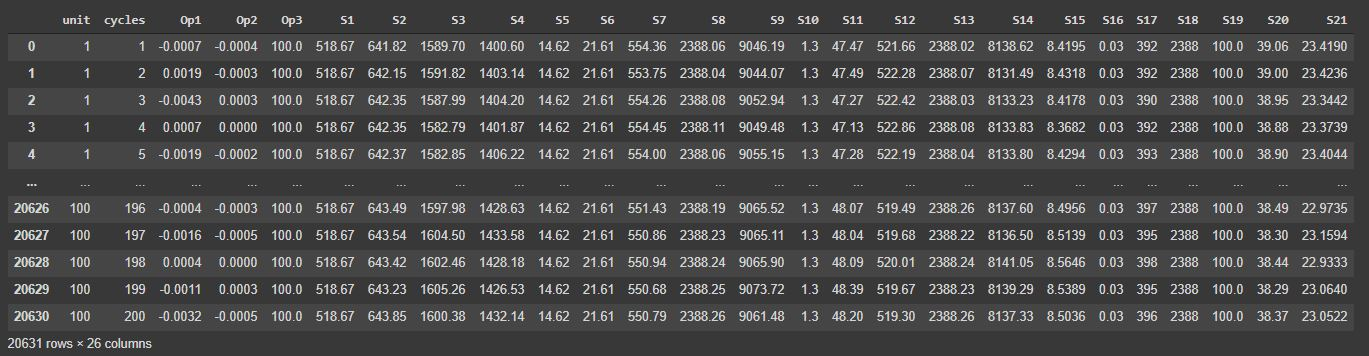

##1.1. Importing and preprocessing the dataset
Firstly, both the train and test datasets are uploaded into the notebook and preprocessed to prepare it for the machine learning process. Unecessary data mostly such as sensors with flatline datas are removed. Constant sensor measurements such as Op3, S1, S5, S6, S9, S16, S10, S18, S19 does not provide any useful degradation information for the RUL predictions. The two datasets are then combined together for feature scaling using sklearn.preprocessing.MinMaxScaler() such that its features lie between between zero and one, and after which they are split again.

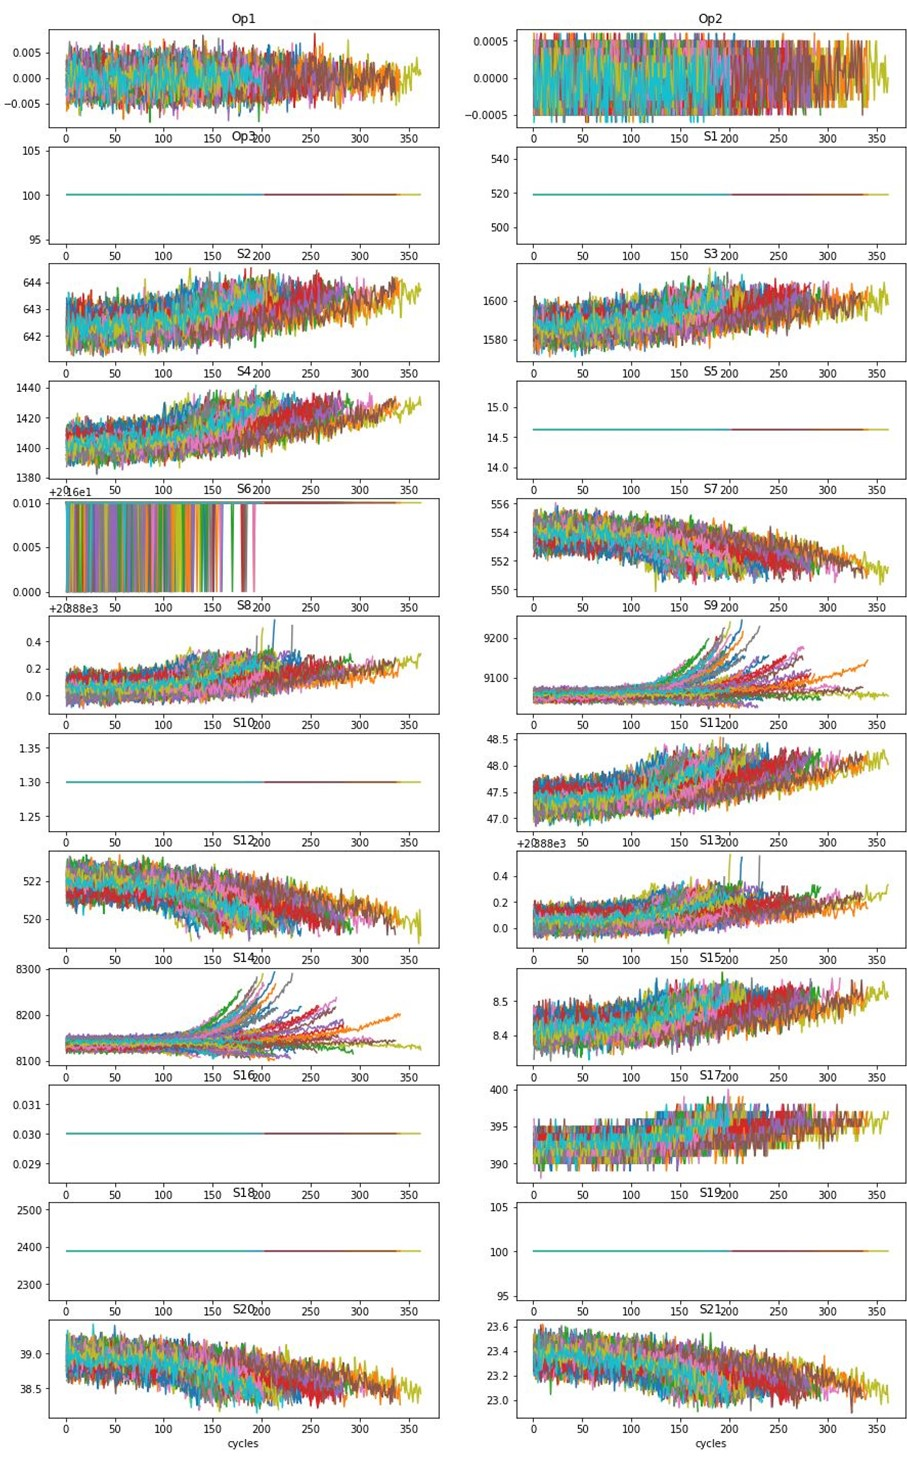

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler

#Importing both test and train datasets
df_test_FD001 = pd.read_csv('/content/gdrive/My Drive/Capstone/test_FD001.txt', sep=' ', header=None)
df_train_FD001 = pd.read_csv('/content/gdrive/My Drive/Capstone/train_FD001.txt', sep=' ', header=None)


# dropping NAN values
df_test_FD001 = df_test_FD001.dropna(axis=1, how='all')
df_train_FD001 = df_train_FD001.dropna(axis=1, how='all')

# Naming the columns
df_test_FD001.columns = ["unit", "cycles", "Op1",
                      "Op2", "Op3", "S1", "S2",
                      "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10", "S11",
                      "S12", "S13", "S14", "S15", "S16", "S17", "S18", "S19", "S20", "S21"]

df_train_FD001.columns = ["unit", "cycles", "Op1",
                      "Op2", "Op3", "S1", "S2",
                      "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10", "S11",
                      "S12", "S13", "S14", "S15", "S16", "S17", "S18", "S19", "S20", "S21"]

# data preprocessing; removing unnecessary data
df_test_FD001.drop(['Op3','S1', 'S5', 'S6', 'S9', 'S16', 'S10', 'S18', 'S19'], axis=1, inplace=True)
df_train_FD001.drop(['Op3','S1', 'S5', 'S6', 'S9', 'S16', 'S10', 'S18', 'S19'], axis=1, inplace=True)

# test dataset begins with unit 101 to differentiate from the train dataset
df_test_FD001['unit'] += 100

# Combine the two datasets into a single dataframe
df_combined = pd.concat([df_train_FD001, df_test_FD001]) 

# Perform scalling on the the combined dataset so that their scale is the same
scaler = MinMaxScaler()
df_combined.iloc[:,2:18] = scaler.fit_transform(df_combined.iloc[:,2:18])

# Split them again after performing scalling
df_train_FD001 = df_combined[(df_combined.unit <= 100)]
df_test_FD001 = df_combined[(df_combined.unit >= 101)]

# After separation, the first unit of the test dataset is reset to 0 again
df_test_FD001['unit'] -= 100

#2. Remaining Useful Life (RUL)
The Remaining Useful Life of an engine unit at any point of the time series is calculated by subtracting the number of cycles where the engine stops oprating (the maximum number of cycles), to the number cycle at the current point of the time series. This value represents the amount of cycles remaining before engine failure. 

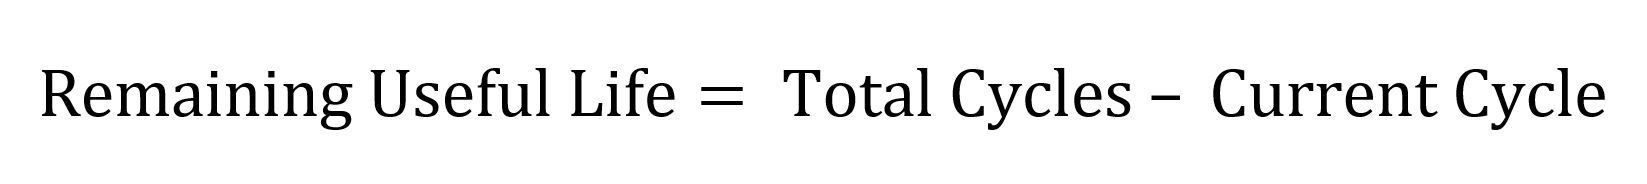


# Health Index (H.I.)
After the RUL is established, the value can be used to calculate the health index of the engine. The health index of the engine represents the state of the engine's health where values closer to one represents a healthier engine and values closer to 0 signifies that the engine reaching the end of its operational life. The health index is caculated by dividing the the current cycle of the time series by the maximum cycles of the unit. *For example, calculating the H.I of an engine at its very first cycle where it is at best health returns a value of one as the RUL of the engine at the first cycle is also equals to the maximum cycles of the engine.*
 
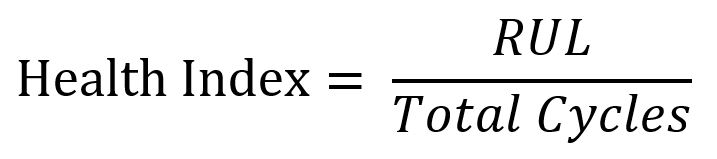

In [ ]:
# Finding the maximum cycle of an engine unit which is used to find its Remaining Useful Life (RUL)
df_train_FD001 = pd.merge(df_train_FD001, df_train_FD001.groupby('unit', as_index=False)['cycles'].max(), how='left', on='unit')
df_train_FD001.rename(columns={"cycles_x": "cycles", "cycles_y": "Total Cycles"}, inplace=True)

df_train_FD001['RUL'] = df_train_FD001['Total Cycles'] - df_train_FD001['cycles']

# Defining the Health Index, where value of 1 denotes healthy engine and 0 denotes failure
def HealthIndex(dataFrame,q):
    return(dataFrame.RUL[q]-dataFrame.RUL.min()) / (dataFrame.RUL.max()-dataFrame.RUL.min())

healthIndex_q = []
healthIndex = []

for i in range(df_train_FD001['unit'].min(), df_train_FD001['unit'].max() + 1):
    dataFrame = df_train_FD001[df_train_FD001.unit == i]
    dataFrame = dataFrame.reset_index(drop = True)
    for q in range(len(dataFrame)):
        healthIndex_q = HealthIndex(dataFrame, q)
        healthIndex.append(healthIndex_q)

df_train_FD001['Health Index'] = healthIndex

#3. Defining test and train data
##3.1 train data
Sensor data values from the **train dataset** are defined as X_train and the Health Index that was calculated in the earlier section defined as y_train. The X_train and y_train data will be used to fit and train the machine learning models.  
<br>
##3.2 test data
Sensor data values from the **test dataset** is defined as X_test. X_test is passed into the trained machine learning model which returns a prediction of engines' Health Index.

In [ ]:
# Defining train values that will be used to train the machine learning model
X_train = df_train_FD001[['cycles', 'Op1', 'Op2', 'S2', 'S3', 'S4', 'S7', 'S8', 'S11', 'S12',
          'S13', 'S14', 'S15', 'S17', 'S20', 'S21']].values
y_train = df_train_FD001[['Health Index']].values.ravel()

# Defining test values that will be used to perform prediction based on the trained model
X_test = df_test_FD001[['cycles', 'Op1', 'Op2', 'S2', 'S3', 'S4', 'S7', 'S8', 'S11', 'S12',
          'S13', 'S14', 'S15', 'S17', 'S20', 'S21']].values

#4. Machine Learning Models
For this project, three machine learning models are used to predict the RUL of an engine.  
The models used are: 1) Linear Regression 2) K Nearest Neighbour 3) Simple Neural Network model.

## 4.1. Linear Regression model
~ insert text here ~

In [ ]:
from sklearn.linear_model import LinearRegression
lreg_model = LinearRegression()
lreg_model.fit(X_train,y_train)


## 4.2. KNN Regressor Model
~ insert text here ~

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knr_model = KNeighborsRegressor(n_neighbors=10)
knr_model.fit(X_train, y_train)

## 4.3. Neural Network Model
~ insert text here ~

In [ ]:
# # Importing keras deep learning API into colab notebook
# from keras.models import Sequential
# from keras.layers.core import Dense, Activation
# from keras.wrappers.scikit_learn import KerasRegressor

# # Defining Neural Network model
# nn_model = Sequential()
# nn_model.add(Dense(50, input_dim=16, kernel_initializer='normal', activation='relu'))
# nn_model.add(Dense(1, activation='relu'))

# # Compiling model
# nn_model.compile(loss='mean_squared_error', optimizer='adam')

# # Training the Neural Network model
# nn_model.fit(X_train, y_train, epochs = 55, shuffle=True, verbose = 0)

## 4.4. Saved Neural Network Model
Alternatively, accurate Neural Network models from previous tests was saved and can be uploaded again to retrieve an accurate prediction.

In [ ]:
import keras

# from tensorflow import keras
nn_model = keras.models.load_model('/content/gdrive/My Drive/Capstone/BestModel')

#5. MachineLearningModel() class and its methods
The MachineLearningModel() class is created to reduce code duplication when multiple machine learning models are used to predict the engine degredation and RUL.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

class MachineLearningModel:
  def __init__(self,model,name,testDataFrame, X_test, OutputDataFrame = None):
    self.model = model
    self.name = name
    self.testDataFrame = testDataFrame
    self.X_test = X_test

    # Values of the predictions and calculations are stored in the test dataframe by default unless an alternate dataframe is specified 
    if OutputDataFrame is not None:
      self.OutputDataFrame = OutputDataFrame
    else:
      self.OutputDataFrame = self.testDataFrame
    

  def predict(self):    
    # Function predicts the Health Index values based on the trained machine learning model.
    Prediction = self.model.predict(self.X_test)

    # The predicted H.I. values are appended into the dataframe 
    self.OutputDataFrame[f'Pred_H.I._{self.name}'] = Prediction

    # Calculating the predicted maximum cycle of the engine units      
    self.OutputDataFrame[f'PredMaxCycles_{self.name}'] = self.OutputDataFrame['cycles'] / (1 - self.OutputDataFrame[f'Pred_H.I._{self.name}'])

  def PlotPredMaxCycles(self,displayUnit=1):
    # Returning the average maximum cycle value of a particular engine unit
    df = self.OutputDataFrame[f'PredMaxCycles_{self.name}']
    meanValue = df[(self.OutputDataFrame['unit'] == displayUnit)][-10:].mean()
    print(f'Mean value of last 10 cycles of engine unit {displayUnit}: {meanValue}') 

    # plotting the predicted maximum cycles
    plt.figure(figsize = (16, 8)) 
    plt.plot(df[(self.OutputDataFrame['cycles'] >0) & (self.OutputDataFrame['unit'] == displayUnit)])
    plt.axhline(meanValue, color="red", linestyle='dashed', linewidth=1.6)

    # set title and axis labels
    errorDist = plt.title(f'Predicted Maximum Cycles of engine unit {displayUnit}', x=0.5, y=1.05, ha='center', fontsize='xx-large')
    plt.setp(errorDist, color='black')

  def DataFrame(self, remove_sensor_data=False):
    # function returns dataframe
    droppedColumns = ['Op1', 'Op2', 'S2', 'S3', 'S4', 'S7', 'S8', 'S11', 'S12',
          'S13', 'S14', 'S15', 'S17', 'S20', 'S21']
    if remove_sensor_data == True:
      self.OutputDataFrame.drop(droppedColumns, axis=1, errors='ignore', inplace=True)
    return self.OutputDataFrame

  def CalcPredMaxCycles(self):
    df = self.OutputDataFrame[f'PredMaxCycles_{self.name}']

    # Returns a uniform PredMaxCycles based on the calculated average of the last 10 cycles 
    for i in range(self.OutputDataFrame['unit'].min(), self.OutputDataFrame['unit'].max() + 1):
        df[(self.OutputDataFrame['unit'] == i)] = df[(self.OutputDataFrame['unit'] == i)][-10:].mean()
  
  def CalcPredRUL(self):
    self.OutputDataFrame[[f'Pred_RUL_{self.name}']] = self.OutputDataFrame[f'PredMaxCycles_{self.name}'] * self.OutputDataFrame[f'Pred_H.I._{self.name}']

    # Appending the RUL values of each engine unit into an array
    df =  self.OutputDataFrame[f'Pred_RUL_{self.name}']
    maxpred = []
    for i in range(1,101):
      maxpred.append(df[(self.OutputDataFrame['unit'] == i)].min())
    return maxpred  

  def PlotRUL(self):
      # Visualizing the predicted cycles of the engine units in the test dataset.
      # x-axis represents the cycles
      df =  self.OutputDataFrame[f'Pred_RUL_{self.name}']
      plt.figure(figsize = (16, 8)) 
      plt.plot(df)

      # set title and axis labels
      plt.title(f'Predicted Remaining Useful Life for {self.name}', x=0.5, y=1.05, ha='center', fontsize='xx-large')
      

  def DisplayEngineRUL(self, displayUnit):
    # Returning the Remaining useful life of an engine unit of the test dataset.
    # It is found by returning the minumum cycle to failure value of each engine unit
    df =  self.OutputDataFrame[f'Pred_RUL_{self.name}'] 
    value = df[(self.OutputDataFrame['unit'] == displayUnit)].min()
    print(f'Predicted RUL of unit {displayUnit}: {value}')

  def GetRMSE(self,actual,predicted):
    # Calculating the Root Mean Square Error of the actual and predicted values
    RMSE = mean_squared_error(actual, predicted, squared=False)
    return RMSE


The Results Dataframe is created where the results of the predictions and calculation for each ML models are stored. 

In [ ]:
Results = df_test_FD001[['unit', 'cycles']]

#6. Prediction
Using the MachineLearning classes that was created earlier, the prediction of the three different models can be made without much code duplication. In this

##6.1 Neural Network model prediction
The test data is predicted using the linear regression model. With the predict() method, the X_test values

In [ ]:
NeuralNetwork = MachineLearningModel(nn_model, 'nn', df_test_FD001, X_test, Results)
NeuralNetwork.predict()

By displaying the last five rows of the dataframe, the predicted RUL of unit 100 based can be calculated by subtracting the final cycle with the predicted maximum cycle (198 - 222) which returns a value of 19. In other words, this means that it is predicted that the engine's operational life will end in approximately 24 cycles.

In [ ]:
# displaying the last 5 rows of the dataframe
NeuralNetwork.DataFrame(True).tail()


Taking unit 20 for example, it is observed that the value of the predicted maximum cycles throughout the timeseries is noisy and unstable. In a perfect world this should not happen as the maximum cycles should be same throughout. As a result, in this project the average value of the last ten cycles is used to represent the predicted maximum cycle of the entire engine unit. For the purpose of this project, these average values are refered as the adjusted predicted maximum cycles. For the example plotted below, the dotted line represent the averaged value used.  

Also below is a snippet of the code used to determine this average value used in the MachineLearningModel.PlotPredMaxCycles(displayUnit = 1) method.    
```
df = self.OutputDataFrame[f'PredMaxCycles_{self.name}']
meanValue = df[(self.OutputDataFrame['unit'] == displayUnit)][-10:].mean()
```



In [ ]:
NeuralNetwork.PlotPredMaxCycles(20)
NeuralNetwork.CalcPredMaxCycles()

After averaging the predicted maximum cycles' values, we can see that it's values are now stable throughout the timeseries.

In [ ]:
NeuralNetwork.PlotPredMaxCycles(20)

With the values of the Predicted Maximum cycles averaged and stable throughout the timeseries, the Predicted RUL can now be calculated by multiplying the Predicted Maximum cycles with the Predicted Health Index.



In [ ]:
RUL_nn = NeuralNetwork.CalcPredRUL()
NeuralNetwork.DataFrame()

In [ ]:
NeuralNetwork.PlotRUL()

## 6.2 K Nearest Neighbour Regressor prediction

In [ ]:
KNRegressor = MachineLearningModel(knr_model, 'knr', df_test_FD001, X_test, Results)
KNRegressor.predict()
KNRegressor.CalcPredMaxCycles()
RUL_knr = KNRegressor.CalcPredRUL()
KNRegressor.DataFrame()[['unit', 'cycles', 'Pred_H.I._knr', 'PredMaxCycles_knr', 'Pred_RUL_knr']]

##6.3 Linear regression model prediction

In [ ]:
LinearRegression = MachineLearningModel(lreg_model, 'lreg', df_test_FD001, X_test, Results)
LinearRegression.predict()
LinearRegression.CalcPredMaxCycles()
RUL_lreg = LinearRegression.CalcPredRUL()
LinearRegression.DataFrame()[['unit', 'cycles', 'Pred_H.I._nn', 'PredMaxCycles_nn', 'Pred_RUL_nn']]

#7. Results and observation

In [ ]:
Results

In [ ]:
FinalResult = pd.read_csv('/content/gdrive/My Drive/Capstone/RUL_FD001.txt', sep=' ', header=None)
FinalResult = FinalResult.dropna(axis=1, how='all')
FinalResult.columns = ["Actual RUL"]

unit = []
for i in range(1,101):
  unit.append(i)

FinalResult['unit'] = unit
FinalResult = FinalResult[['unit', 'Actual RUL']]

FinalResult['Pred_RUL_lreg'] = RUL_lreg
FinalResult['lreg_diff'] = FinalResult['Actual RUL'] - FinalResult['Pred_RUL_lreg']

FinalResult['Pred_RUL_knr'] = RUL_knr
FinalResult['knr_diff'] = FinalResult['Actual RUL'] - FinalResult['Pred_RUL_knr']

FinalResult['Pred_RUL_nn'] = RUL_nn
FinalResult['nn_diff'] = FinalResult['Actual RUL'] - FinalResult['Pred_RUL_nn']

FinalResult

# Root Mean Square Error (RMSE)
RMSE is calculated by taking the square root of the average of the squared differences between the actual and predicted values. This value is able to represent the estimation of the the standard deviation σ of a typical observed value from the model’s prediction. 

![RMSE calculation](https://miro.medium.com/max/725/1*lqDsPkfXPGen32Uem1PTNg.png) 

In [ ]:
RMSE_nn = NeuralNetwork.GetRMSE(FinalResult['Actual RUL'], FinalResult['Pred_RUL_nn'])
RMSE_knr = KNRegressor.GetRMSE(FinalResult['Actual RUL'], FinalResult['Pred_RUL_knr'])
RMSE_lreg = LinearRegression.GetRMSE(FinalResult['Actual RUL'], FinalResult['Pred_RUL_lreg'])

print('Neural Network RMSE:', RMSE_nn)
print('K Nearest Neighbour RMSE:', RMSE_knr)
print('Linear Regression RMSE:', RMSE_lreg)

# Error Distribution
Plotting the absolute error distribution of the models below, it is observed that the error distribution for all three models are shifted towards the left. This means that there is tendancy for the predicted RUL values to overshoot the actual values. 

In [ ]:
plt.figure(figsize=(20,10))
plt.tight_layout()

FinalResult['lreg_diff'].plot(label = 'Linear Regression', kind = 'kde', legend = True)
FinalResult['knr_diff'].plot(label = 'K Nearest Neighbour', kind = 'kde', legend = True)
FinalResult['nn_diff'].plot(label = 'Neural Network', kind = 'kde', legend = True)
plt.axvline(0, color="black", linestyle='dashed', linewidth=1.6)

# set title and axis labels
errorDist = plt.title('Error distribution', x=0.5, y=1.05, ha='center', fontsize='30')
plt.setp(errorDist, color = 'black')

plt.show()